# iEEG Data Interpolation and Evaluation 

This notebook performs Linear both interpolation and K Nearest Neighbour interpolation on iEEG data and evaulates accuracy. 


## Linear Interpolation 

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
import pandas as pd

Processing Delta Band...


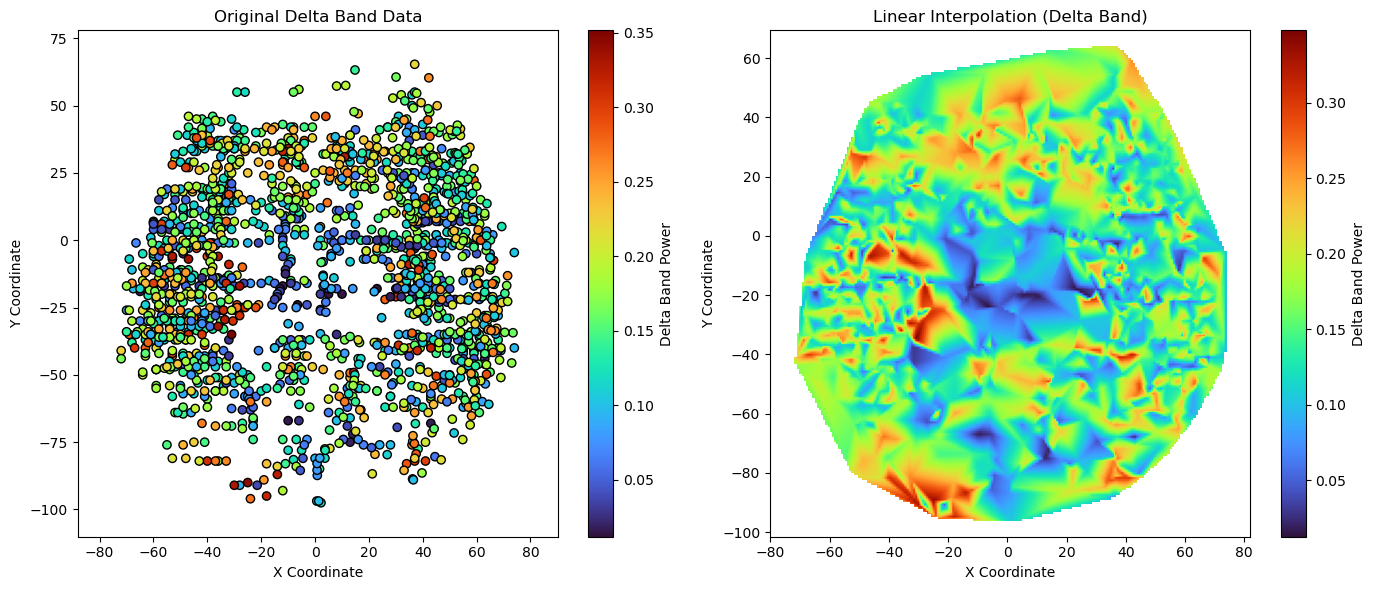

Processing Theta Band...


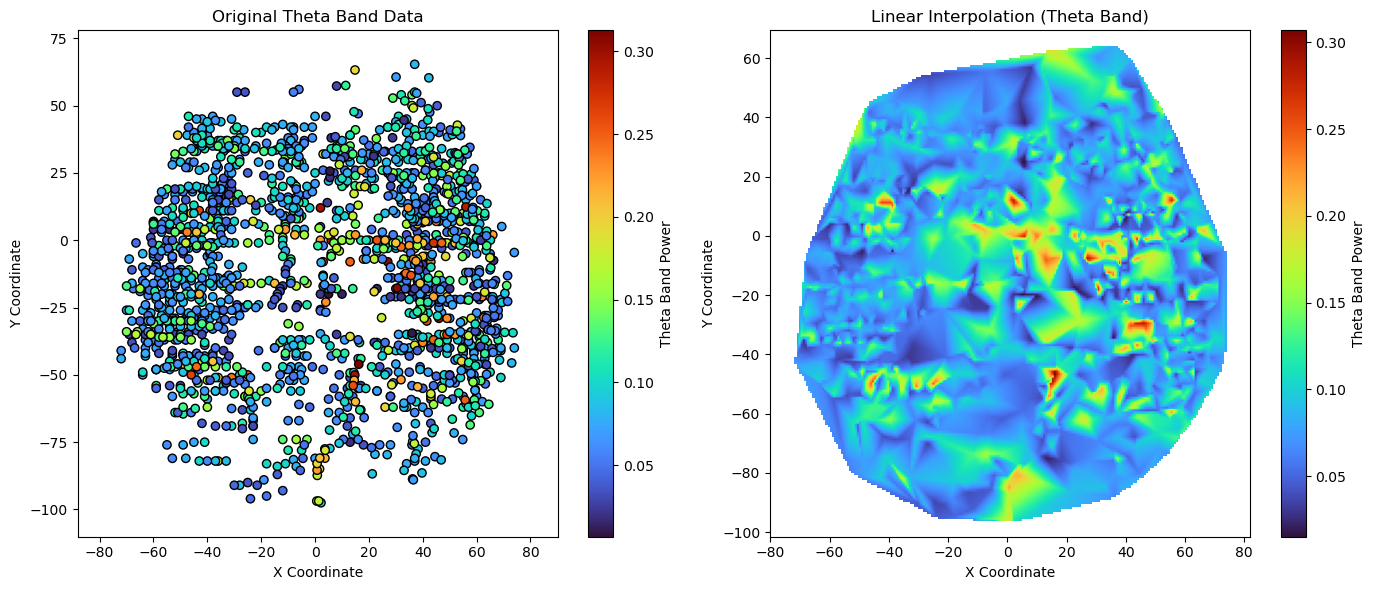

Processing Alpha Band...


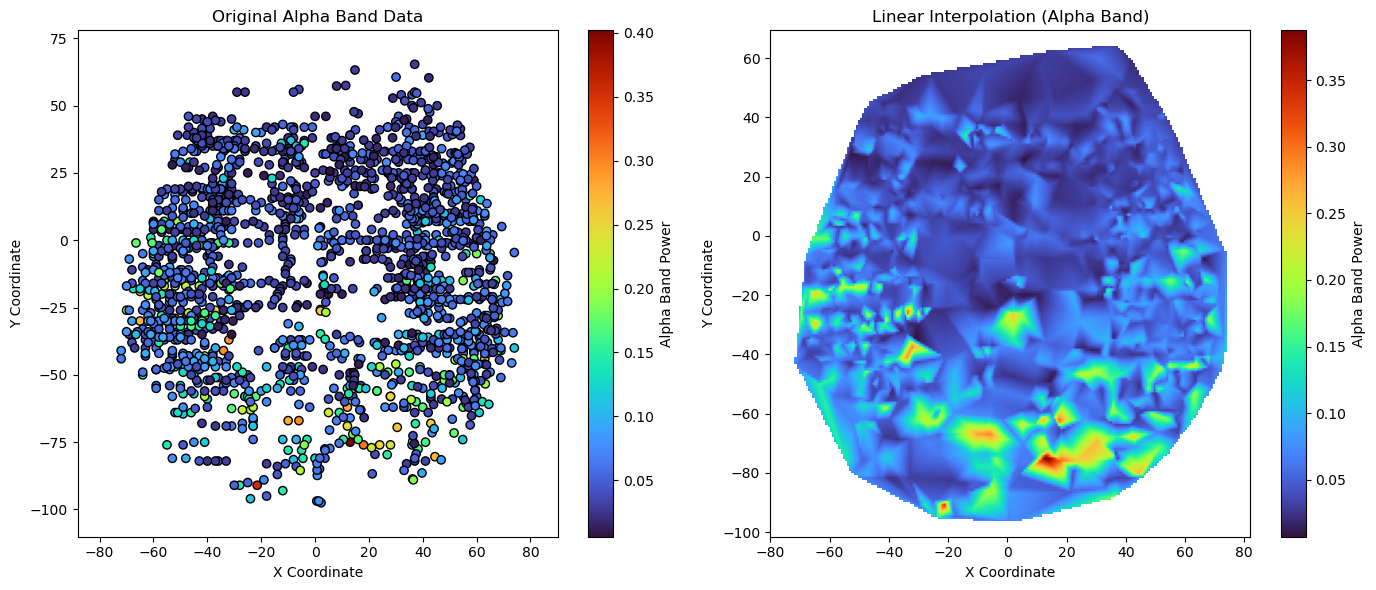

Processing Beta Band...


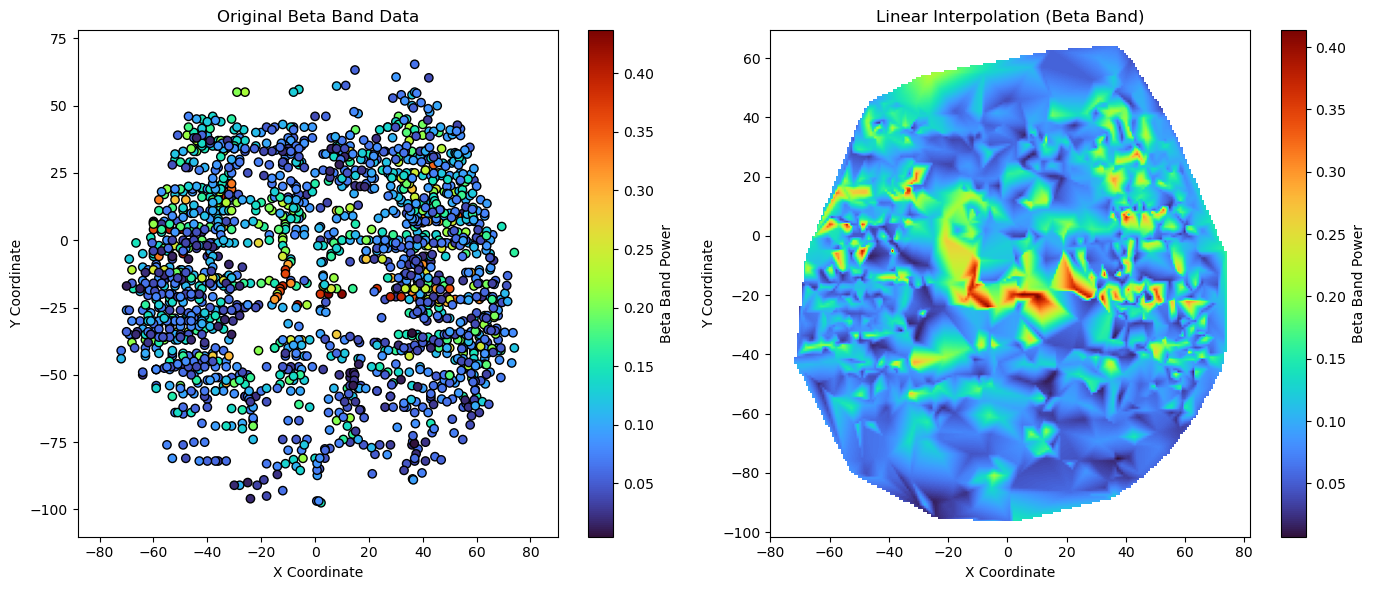

Processing Gamma Band...


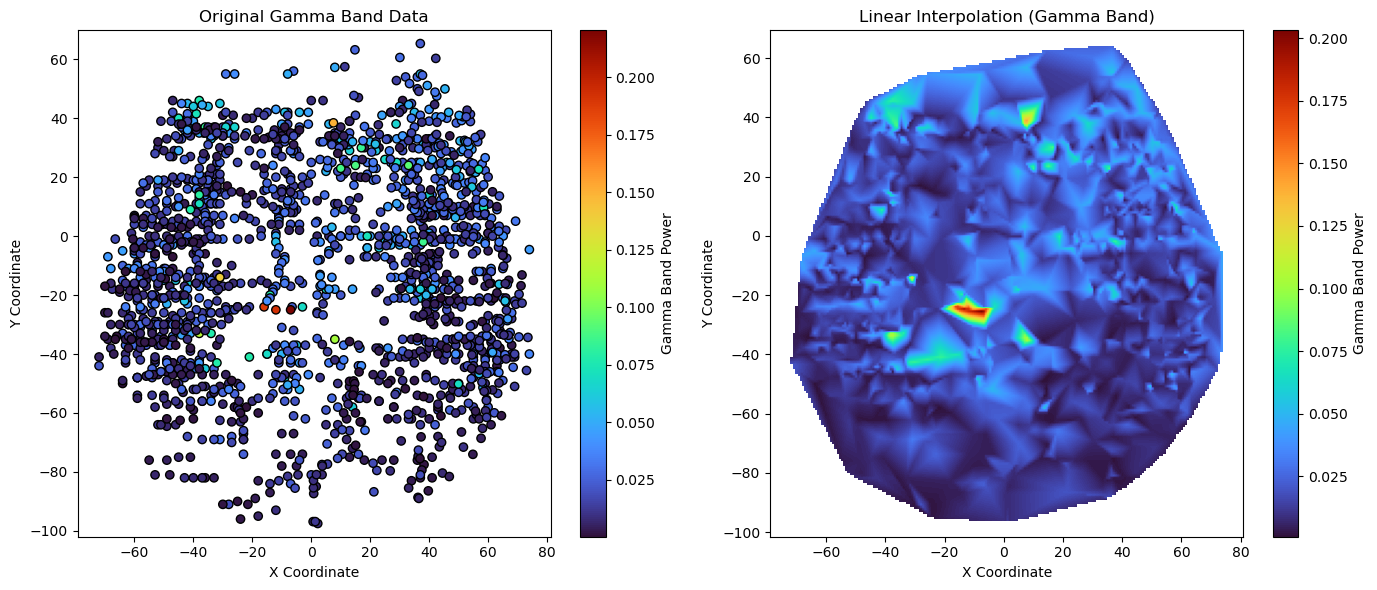


Interpolation Evaluation Metrics:
            MSE       MAE      RMSE        R²
Delta  0.000393  0.003267  0.019813  0.918347
Theta  0.000172  0.002177  0.013130  0.928195
Alpha  0.000245  0.002059  0.015644  0.896958
Beta   0.000252  0.002543  0.015873  0.950866
Gamma  0.000026  0.000775  0.005138  0.921488


In [8]:
# Load the data
coords = np.load('coords.npy')
band_powers = np.load('band_powers.npy', allow_pickle=True).item()

# Extract x, y coordinates (assuming these are the relevant spatial coordinates)
x, y = coords[:, 0], coords[:, 1]

# Define a grid for interpolation
resolution = 200  # Define resolution for interpolation
grid_x, grid_y = np.meshgrid(
    np.linspace(min(x), max(x), resolution),
    np.linspace(min(y), max(y), resolution)
)

# Prepare a dictionary to store evaluation metrics
evaluation_metrics = {}

# Iterate over each frequency band and perform linear interpolation
for band, values in band_powers.items():
    print(f'Processing {band} Band...')

    # Perform linear interpolation
    grid_values = griddata((x, y), values, (grid_x, grid_y), method='linear')

    # Evaluate interpolation accuracy by comparing interpolated values at the original points
    interp_values_at_samples = griddata((x, y), values, (x, y), method='linear')

    mse = mean_squared_error(values, interp_values_at_samples)
    mae = mean_absolute_error(values, interp_values_at_samples)
    rmse = sqrt(mse)
    r2 = r2_score(values, interp_values_at_samples)

    evaluation_metrics[band] = {
        "MSE": mse,
        "MAE": mae,
        "RMSE": rmse,
        "R²": r2
    }

    # Plot original vs interpolated data
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Scatter plot of original data
    sc = axes[0].scatter(x, y, c=values, cmap='turbo', edgecolors='k')
    axes[0].set_title(f'Original {band} Band Data')
    axes[0].set_xlabel('X Coordinate')
    axes[0].set_ylabel('Y Coordinate')
    axes[0].axis('equal')
    fig.colorbar(sc, ax=axes[0], label=f'{band} Band Power')

    # Heatmap of interpolated data
    i = axes[1].imshow(grid_values, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap='turbo')
    axes[1].set_title(f'Linear Interpolation ({band} Band)')
    axes[1].set_xlabel('X Coordinate')
    axes[1].set_ylabel('Y Coordinate')
    axes[1].axis('equal')
    fig.colorbar(i, ax=axes[1], label=f'{band} Band Power')

    plt.tight_layout()
    plt.show()

# Convert evaluation metrics into a DataFrame and display
df_metrics = pd.DataFrame(evaluation_metrics).T
print("\nInterpolation Evaluation Metrics:")
print(df_metrics)


## KNN Interpolation

In [9]:
from sklearn.neighbors import KNeighborsRegressor

Processing Delta Band using KNN Interpolation...


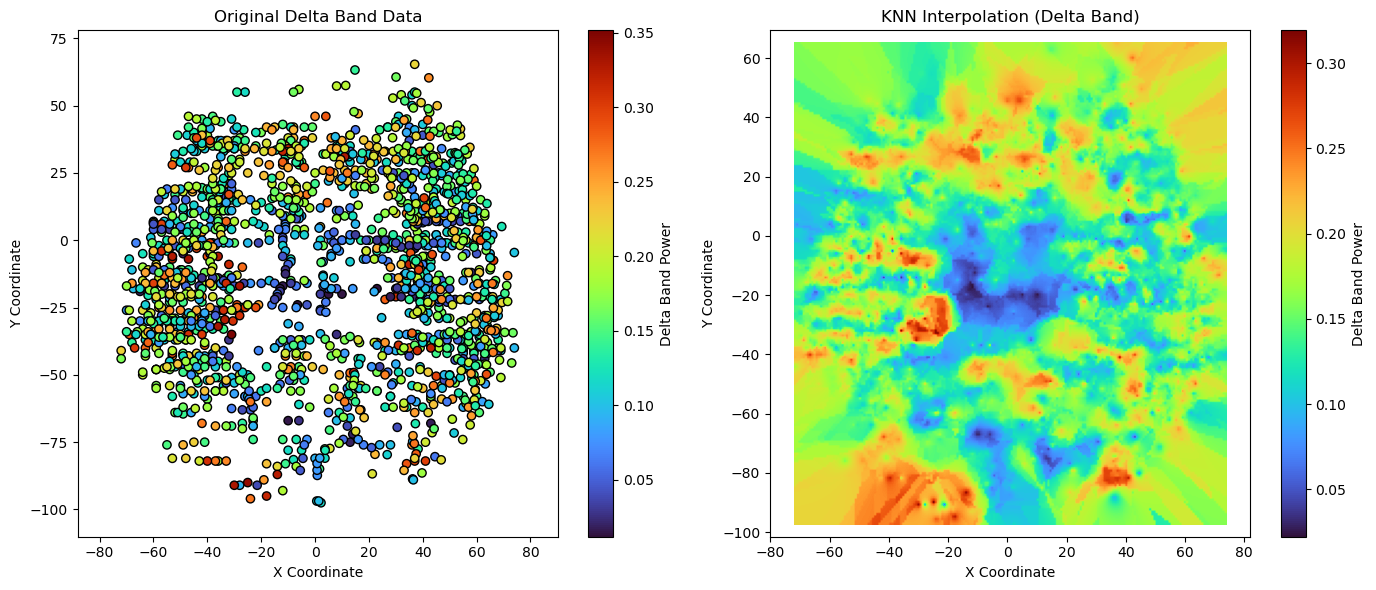

Processing Theta Band using KNN Interpolation...


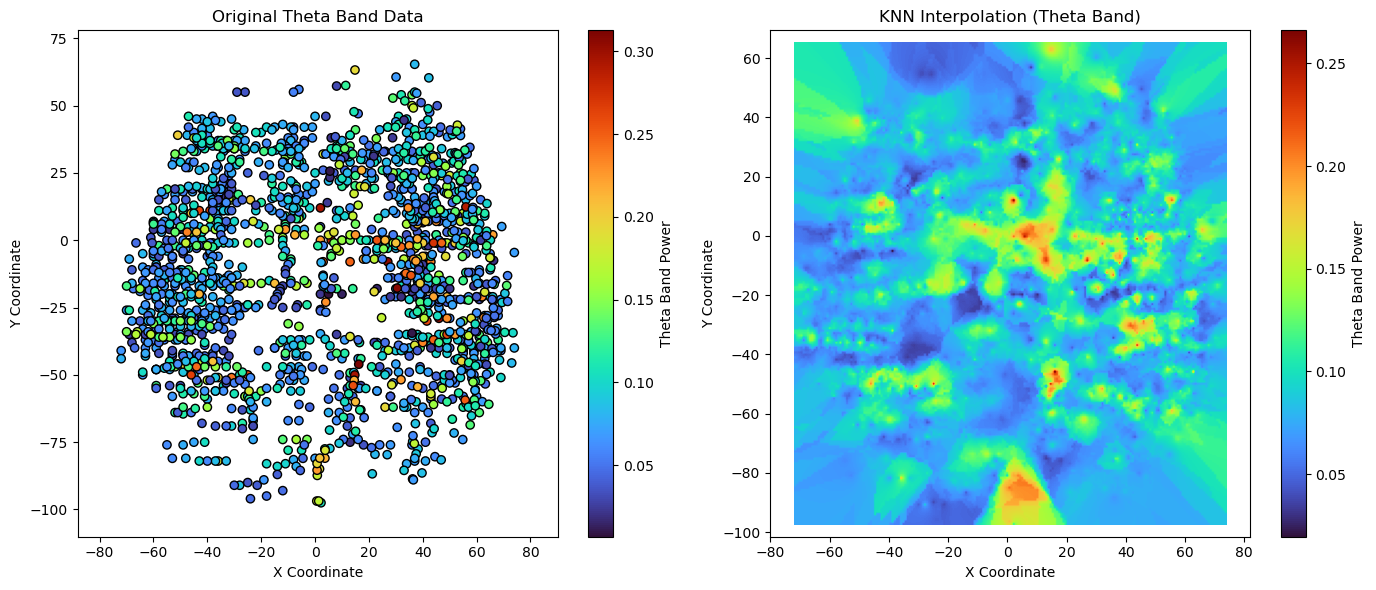

Processing Alpha Band using KNN Interpolation...


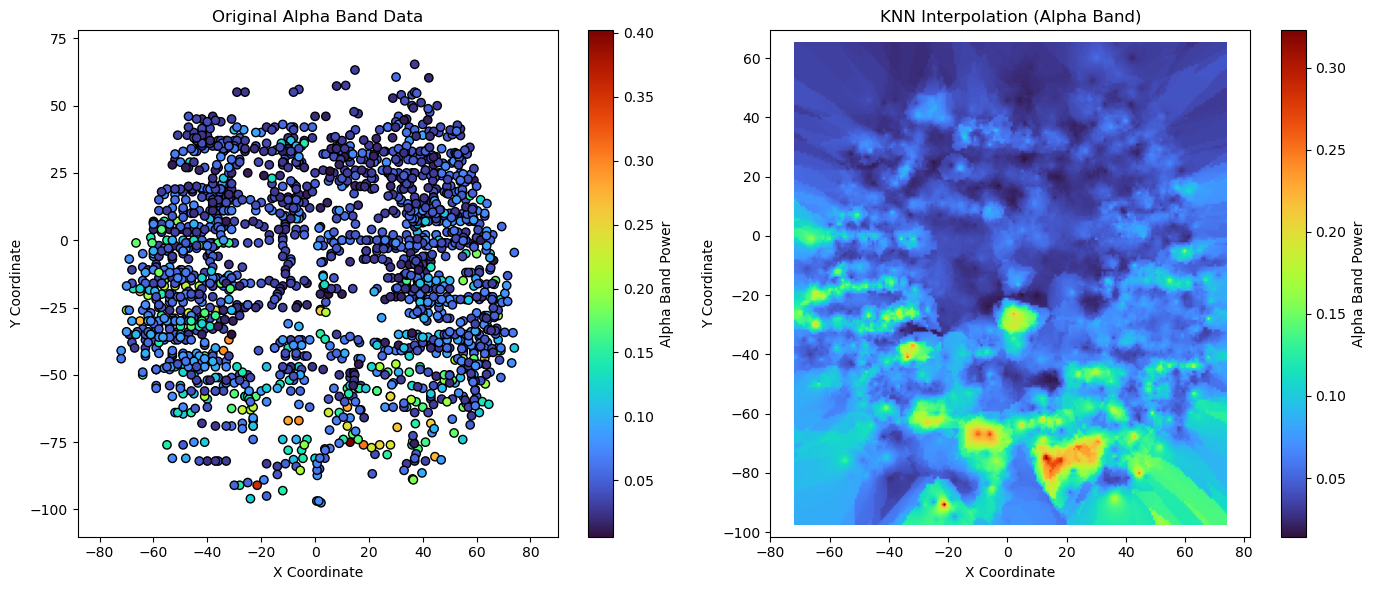

Processing Beta Band using KNN Interpolation...


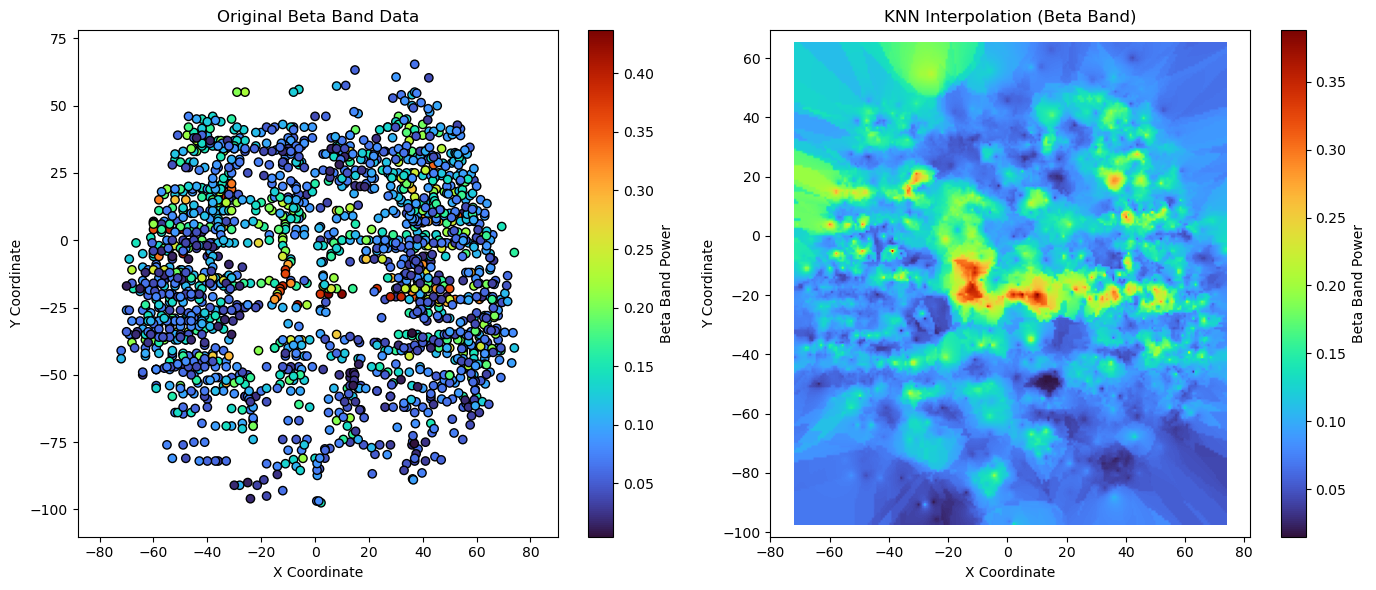

Processing Gamma Band using KNN Interpolation...


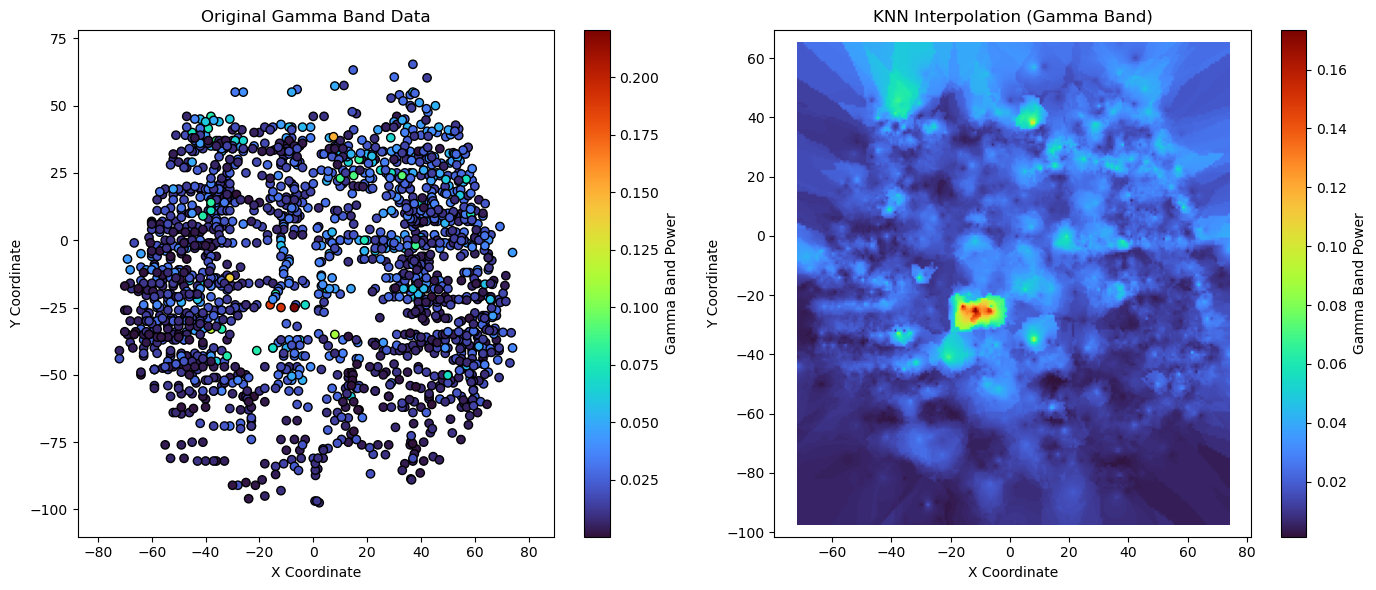


KNN Interpolation Evaluation Metrics:
            MSE       MAE      RMSE        R²
Delta  0.000199  0.003240  0.014091  0.958702
Theta  0.000090  0.002203  0.009474  0.962616
Alpha  0.000124  0.002052  0.011127  0.947866
Beta   0.000130  0.002555  0.011399  0.974659
Gamma  0.000013  0.000753  0.003602  0.961403


In [10]:
# Load the data
coords = np.load('coords.npy')
band_powers = np.load('band_powers.npy', allow_pickle=True).item()

# Extract x, y coordinates
x, y = coords[:, 0], coords[:, 1]
xy_points = np.column_stack((x, y))  # Create a 2D array of coordinates

# Define a grid for interpolation
resolution = 200
grid_x, grid_y = np.meshgrid(
    np.linspace(min(x), max(x), resolution),
    np.linspace(min(y), max(y), resolution)
)

# Flatten the grid for KNN predictions
grid_points = np.column_stack((grid_x.ravel(), grid_y.ravel()))

# Prepare dictionary for evaluation metrics
evaluation_metrics = {}

# Iterate over each frequency band and perform KNN interpolation
for band, values in band_powers.items():
    print(f'Processing {band} Band using KNN Interpolation...')

    # Initialize KNN Regressor (using 5 neighbors as default)
    knn = KNeighborsRegressor(n_neighbors=5, weights='distance') #Gives more importance to closer points

    # Fit the KNN model to the band power data
    knn.fit(xy_points, values)

    # Predict interpolated values for the grid
    grid_values = knn.predict(grid_points).reshape(grid_x.shape)

    # Evaluate interpolation accuracy by comparing interpolated values at original sample points
    interp_values_at_samples = knn.predict(xy_points)

    mse = mean_squared_error(values, interp_values_at_samples)
    mae = mean_absolute_error(values, interp_values_at_samples)
    rmse = sqrt(mse)
    r2 = r2_score(values, interp_values_at_samples)

    evaluation_metrics[band] = {
        "MSE": mse,
        "MAE": mae,
        "RMSE": rmse,
        "R²": r2
    }

    # Plot original vs interpolated data
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Scatter plot of original data
    sc = axes[0].scatter(x, y, c=values, cmap='turbo', edgecolors='k')
    axes[0].set_title(f'Original {band} Band Data')
    axes[0].set_xlabel('X Coordinate')
    axes[0].set_ylabel('Y Coordinate')
    axes[0].axis('equal')
    fig.colorbar(sc, ax=axes[0], label=f'{band} Band Power')

    # Heatmap of interpolated data
    i = axes[1].imshow(grid_values, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap='turbo')
    axes[1].set_title(f'KNN Interpolation ({band} Band)')
    axes[1].set_xlabel('X Coordinate')
    axes[1].set_ylabel('Y Coordinate')
    axes[1].axis('equal')
    fig.colorbar(i, ax=axes[1], label=f'{band} Band Power')

    plt.tight_layout()
    plt.show()

# Convert evaluation metrics into a DataFrame and display
df_metrics = pd.DataFrame(evaluation_metrics).T
print("\nKNN Interpolation Evaluation Metrics:")
print(df_metrics)
